# 02456 - Deep Learning Project

Group members:
 - Benjamin Pedersen Rasmussen (s234911)
 - Raquel Moleiro Marques (s243636)
 - Sree Keerthi Desu (s243933)
 - Ting-Hui Cheng (s232855)

### Imports

In [17]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import os
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from torch.nn.parameter import Parameter
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split

## Data Preparation

In [8]:
image_list = []

# Specify the folder path
folder_path = "data/photo_jpg"

# Get a list of all the image files in the folder
image_files = [
    f for f in os.listdir(folder_path) if f.endswith(".jpg") or f.endswith(".png")
]

# Iterate through the image files
for image_file in image_files:
    # Open the image file
    img = Image.open(os.path.join(folder_path, image_file))
    # Convert the image to an array
    img_array = np.array(img)
    # Append the image array to the list
    image_list.append(img_array)
#
# print(image_list)

# Exploratory Data Analysis (EDA)

In [9]:
# access folders
path_monet = "data/monet_jpg/"
path_photo = "data/photo_jpg/"

print("Number of monet paintings: {}".format(len(os.listdir(path_monet))))
print("Number of photos: {}".format(len(os.listdir(path_photo))))

Number of monet paintings: 300
Number of photos: 7038


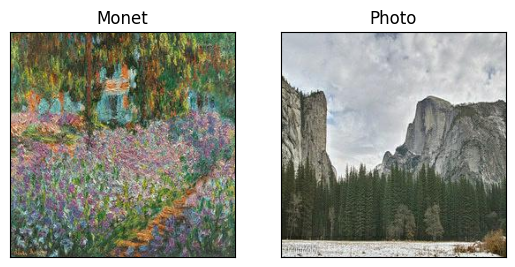

In [10]:
random_index = int(np.random.uniform(0, len(os.listdir(path_monet))))
example_monet = os.listdir(path_monet)[random_index]
example_photo = os.listdir(path_photo)[random_index]

plt.subplot(121)
plt.title('Monet')
plt.imshow(Image.open(os.path.join(path_monet, example_monet)))
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.title('Photo')
plt.imshow(Image.open(os.path.join(path_photo, example_photo)))
plt.xticks([])
plt.yticks([])
plt.show()

In [11]:
# function to display the present color channels in an image alongside the image itself
def display_color_channels(path):
    plt.figure(figsize=(16, 4))
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis("off")
    
    colors = ["red", "green", "blue"]
    for i in range(len(colors)):
        plt.subplot(1, 4, i + 2)
        plt.hist(
            img[:, :, i].reshape(-1),
            bins=50,
            color=colors[i],
            density=True
        )
        plt.xlim(0, 255)
        plt.xticks([])
        plt.yticks([])
     
    plt.show()

Monet:


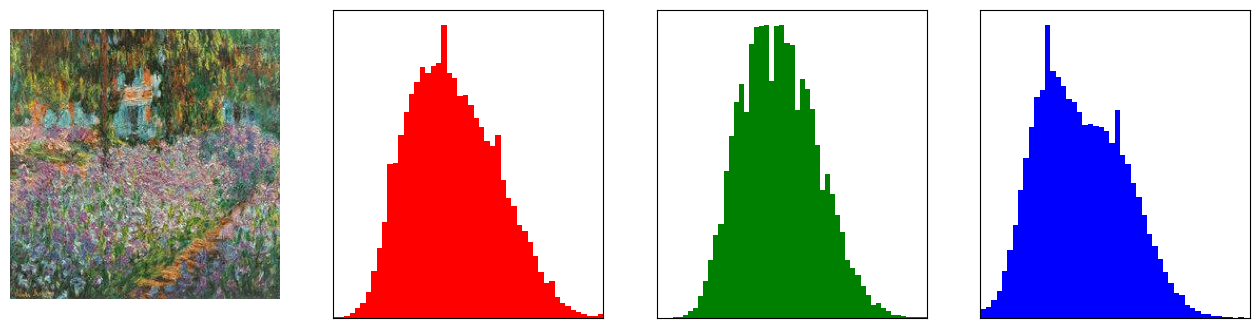

Photo:


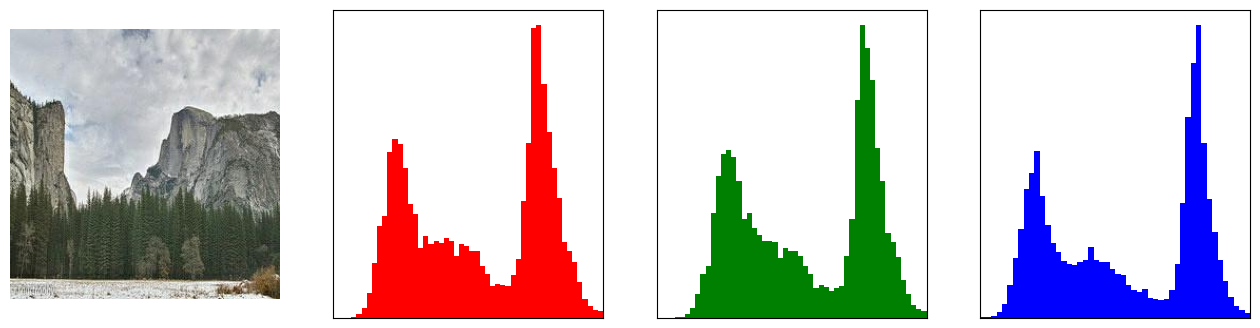

In [12]:
# show monet example color channels
print("Monet:")
display_color_channels(os.path.join(path_monet, example_monet))
print("Photo:")
display_color_channels(os.path.join(path_photo, example_photo))

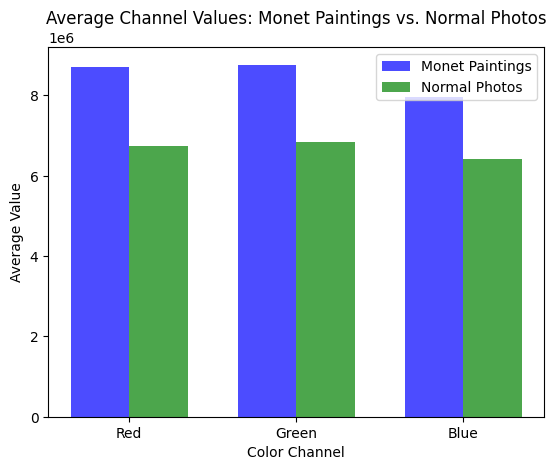

In [13]:
# function to calculate the average channel values (Red, Green, Blue)
def calculate_average_channel_values(image_dir):
    
    # init each channel (R, G, B)
    channel_sum = np.zeros(3) 
    total_images = 0

    for image_filename in os.listdir(image_dir):
        img = Image.open(os.path.join(image_dir, image_filename))
        img_array = np.array(img)
        
        # make sure it is a color image
        if img_array.shape == (256, 256, 3):
            channel_sum += np.sum(img_array, axis=(0, 1))
            total_images += 1

    average_channel_values = channel_sum / total_images
    return average_channel_values

# calculate average channel values
average_monet_values = calculate_average_channel_values(path_monet)
average_photos_values = calculate_average_channel_values(path_photo)

# ceate bar charts to compare average channel values
channels = ['Red', 'Green', 'Blue']
x = np.arange(len(channels))
width = 0.35

plt.bar(x - width/2, average_monet_values, width, label='Monet Paintings', color='b', alpha=0.7)
plt.bar(x + width/2, average_photos_values, width, label='Normal Photos', color='g', alpha=0.7)

plt.xlabel('Color Channel')
plt.ylabel('Average Value')
plt.title('Average Channel Values: Monet Paintings vs. Normal Photos')
plt.xticks(x, channels)
plt.legend()
plt.show()

# Model Building

In [25]:
IMAGE_SIZE = [256,256]

class DataLoader(Dataset):
    def __init__(self, _path, transform=True):
        self._path = _path
        # Memoize path indices for later
        self.monet_indices = dict()
        self.photo_indices = dict()

        if transform:
            # Default 0-1 norm´
            self.transform = transforms.Compose((
                transforms.Resize(IMAGE_SIZE, antialias=False),
                transforms.ToTensor(),
                
                )
            )
        self.monets = os.listdir(_path + "/monet_jpg")
        self.photos = os.listdir(_path + "/photo_jpg")

        for i, fl in enumerate(os.listdir("data/monet_jpg")):
            self.monet_indices[i] = fl
        for i, fl in enumerate(os.listdir("data/photo_jpg")):
            self.photo_indices[i] = fl

    def __len__(self):
        return min(len(self.monets), len(self.photos))

    def __getitem__(self, index):
        random_index = int(np.random.uniform(0, len(self.monet_indices.keys())))
        monet_src = Image.open(os.path.join(self._path, "monet_jpg", self.monet_indices[index % 300]))   
        photo_src = Image.open(os.path.join(self._path, "photo_jpg", self.photo_indices[random_index]))
        monet_src = self.transform(monet_src)
        photo_src = self.transform(photo_src)
        return photo_src, monet_src

train_loader = DataLoader("./data")



In [18]:
def MiFID():
    # Torch metrics
    pass


In [31]:
LATENT_DIM = 100

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")


def upsample():
    pass

def downsample():
    pass

def generator(device):
    global gen
    gen = torch.nn.Sequential(
        nn.ConvTranspose2d(LATENT_DIM, 256, kernel_size=3, stride=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
        nn.Sigmoid(),
    ).to(device)
    return gen

def discriminator(device):
    global dis
    dis = torch.nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=4, stride=2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, kernel_size=4, stride=2),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 256, kernel_size=4, stride=2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),
        Flatten(),
        nn.Linear(256, 1),
        nn.Sigmoid(),
    ).to(device)
    return dis

def convLayer():
    pass

def init_weights():
    pass

class ResBlock():
    pass


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

loss = nn.BCELoss()
gen_optim = torch.optim.Adam(
    generator(device)
    .parameters(), 2e-4, 
    betas=(0.5, 0.999)
)
dis_optim = torch.optim.Adam(
    discriminator(device)
    .parameters(), 2e-4, 
    betas=(0.5, 0.999)
)

In [15]:
# Dummy values and boilerplate for now

class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()

    def init_weights(self):
        pass

    def train(self):
        pass

model = Model()
# optimizer = optim.SGD(model.parameters())

In [35]:
# Training loop

from torch.autograd import Variable
import os

tmp_img = "tmp_gan_out.png"
discriminator_loss, generator_loss = [], []

num_epochs = 50
for epoch in range(num_epochs):
    batch_d_loss, batch_g_loss = [], []

    for x, _ in train_loader:
        batch_size = x.size(0)
        # True data is given label 1, while fake data is given label 0
        true_label = torch.ones(batch_size, 1).to(device)
        fake_label = torch.zeros(batch_size, 1).to(device)

        discriminator(device).zero_grad()
        generator(device).zero_grad()

        # Step 1. Send real data through discriminator
        #         and backpropagate its errors.
        x_true = Variable(x).to(device)
        output = discriminator(x_true)

        error_true = loss(output, true_label)
        error_true.backward()

        # Step 2. Generate fake data G(z), where z ~ N(0, 1)
        #         is a latent code.
        z = torch.randn(batch_size, LATENT_DIM, 1, 1)
        z = Variable(z, requires_grad=False).to(device)

        x_fake = generator(z)

        # Step 3. Send fake data through discriminator
        #         propagate error and update D weights.
        # --------------------------------------------
        # Note: detach() is used to avoid compounding generator gradients
        output = discriminator(x_fake.detach())

        error_fake = loss(output, fake_label)
        error_fake.backward()
        dis_optim.step()

        # Step 4. Send fake data through discriminator _again_
        #         propagate the error of the generator and
        #         update G weights.
        output = discriminator(x_fake)

        error_generator = loss(output, true_label)
        error_generator.backward()
        gen_optim.step()

        batch_d_loss.append((error_true / (error_true + error_fake)).item())
        batch_g_loss.append(error_generator.item())

    discriminator_loss.append(np.mean(batch_d_loss))
    generator_loss.append(np.mean(batch_g_loss))

    # -- Plotting --
    f, axarr = plt.subplots(1, 2, figsize=(18, 7))

    # Loss
    ax = axarr[0]
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")

    ax.plot(np.arange(epoch + 1), discriminator_loss)
    ax.plot(np.arange(epoch + 1), generator_loss, linestyle="--")
    ax.legend(["Discriminator", "Generator"])

    # Latent space samples
    ax = axarr[1]
    ax.set_title("Samples from generator")
    ax.axis("off")

    rows, columns = 8, 8

    # Generate data
    with torch.no_grad():
        z = torch.randn(rows * columns, LATENT_DIM, 1, 1)
        z = Variable(z, requires_grad=False).to(device)
        x_fake = generator(z)

    canvas = np.zeros((28 * rows, columns * 28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i * 28 : (i + 1) * 28, j * 28 : (j + 1) * 28] = x_fake.data[idx]
    ax.imshow(canvas, cmap="gray")

    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))
    clear_output(wait=True)

    os.remove(tmp_img)

AttributeError: 'Sequential' object has no attribute 'size'